# Learning to Control Burgers with Differentiable Physics
This notebook will walk you through data generation, supervised network initialization and end-to-end training using our differentiable PDE solver, [Φ<sub>Flow</sub>](https://github.com/tum-pbs/PhiFlow).

The code below replicates experiment 1 from the ICLR 2020 paper [Learning to Control PDEs with Differentiable Physics](https://openreview.net/forum?id=HyeSin4FPB). The original experiment was performed on an older version of the solver. The corresponding code can be found under `/legacy` but is more difficult to understand and not as well documented.

In [1]:
import sys; sys.path.append('../PhiFlow'); sys.path.append('../src')
from control.pde.burgers import InitialState, GaussianForce
from phi.flow import *

## Data Generation

In [2]:
domain = Domain([128], box=box[0:1])  # 1D Grid resolution and physical size
viscosity = 0.003125  # Viscosity constant for Burgers equation
step_count = 32  # how many solver steps to perform, equal to (sequence length - 1)
dt = 0.03125  # Time increment per solver step

Let's have a look at an example Burgers simulation with Gaussian forcing.

*Hint: You can execute the cell below multiple times to get different results.*

Force: -1.2728729223141049 at 0.46858477668671883


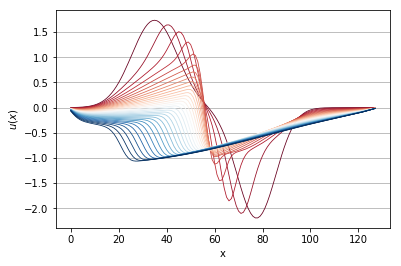

In [18]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
jet = cm = plt.get_cmap('RdBu')
cNorm  = colors.Normalize(vmin=0, vmax=32)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

world = World()
u = BurgersVelocity(domain, velocity=InitialState(1), viscosity=viscosity)
u = world.add(u, physics=Burgers(diffusion_substeps=4))
force = world.add(FieldEffect(GaussianForce(1), ['velocity']))
print('Force: %s at %s' % (force.field.forceamp[0], force.field.forceloc[0]))
plt.plot(u.velocity.data[0,:,0], color=scalarMap.to_rgba(0), linewidth=0.8)
for frame in range(1, step_count + 1):
    world.step(dt=dt)
    plt.plot(u.velocity.data[0,:,0], color=scalarMap.to_rgba(frame+1), linewidth=0.8)
plt.ylabel("$u(x)$")
plt.xlabel("x")
plt.grid(True, axis='y')

Next, we define how many examples to generate and where to store them.

In [3]:
data_path = '~/phi/data/control/forced-burgers-clash'
scene_count = 1000  # how many examples to generate (training + validation + test)
batch_size = 10  # How many examples to generate in parallel

The following cell will generate and store the data.

In [5]:
for batch_index in range(scene_count // batch_size):
    scene = Scene.create(data_path, count=batch_size)
    print(scene)
    world = World()
    u = u0 = BurgersVelocity(domain, velocity=InitialState(batch_size), viscosity=viscosity, batch_size=batch_size, name='burgers')
    u = world.add(u, physics=Burgers(diffusion_substeps=4))
    force = world.add(FieldEffect(GaussianForce(batch_size), ['velocity']))
    scene.properties = {"dimensions": domain.resolution.tolist(), "viscosity": viscosity, "force": force.field.forceamp.tolist()}
    scene.write(world.state, frame=0)
    for frame in range(1, step_count + 1):
        world.step(dt=dt)
        scene.write(world.state, frame=frame)

/home/holl/phi/data/control/forced-burgers-clash/sim_001380
/home/holl/phi/data/control/forced-burgers-clash/sim_001390
/home/holl/phi/data/control/forced-burgers-clash/sim_001400
/home/holl/phi/data/control/forced-burgers-clash/sim_001410
/home/holl/phi/data/control/forced-burgers-clash/sim_001420
/home/holl/phi/data/control/forced-burgers-clash/sim_001430
/home/holl/phi/data/control/forced-burgers-clash/sim_001440
/home/holl/phi/data/control/forced-burgers-clash/sim_001450
/home/holl/phi/data/control/forced-burgers-clash/sim_001460
/home/holl/phi/data/control/forced-burgers-clash/sim_001470


KeyboardInterrupt: 

To delete the generated data, uncomment and run the cell below.

In [ ]:
#for scene in Scene.list('~/phi/data/control/forced-burgers-clash'): scene.remove()

# Supervised Initialization

We can use a supervised observation loss to initialize the OP networks. Compared to the end-to-end training with a differentiable physics loss, this optimization is very fast.

In [4]:
from control.pde.burgers import BurgersPDE
from control.control_training import ControlTraining
from control.sequences import StaggeredSequence, RefinedSequence

Define what part of the data is used for training, validation and testing.

In [5]:
test_range = range(100)
val_range = range(100, 200)
train_range = range(200, 1000)

The following cell trains all OP$_n \,\, \forall n\in\{2,4,8,16,32\}$.
The `ControlTraining` class is used to set up the optimization problem.

The loss for the supervised initialization is defined as the observation loss at the center frame.

$\boldsymbol L_o^\textrm{sup} = \left|\mathrm{OP}[o(t_i),o(t_j)] - u^\textrm{GT}\left(\frac{t_i+t_j}{2}\right)\right|^2.$

Consequently, no sequence needs to be simulated (`sequence_class=None`) and an observation loss is required at frame $\frac n 2$ (`obs_loss_frames=[n // 2]`).
The pretrained network checkpoints are stored in `checkpoint_dict`.

In [7]:
import tensorflow as tf; tf.reset_default_graph()
checkpoint_dict = {}

for n in [2, 4, 8, 16, 32]:
    app = ControlTraining(n,
                          BurgersPDE(),
                          datapath=data_path,
                          val_range=val_range,
                          train_range=train_range,
                          trace_to_channel=lambda trace: 'burgers_velocity',
                          obs_loss_frames=[n // 2],
                          trainable_networks=['OP%d' % n],
                          sequence_class=None,
                          batch_size=100,
                          view_size=20,
                          learning_rate=1e-3,
                          learning_rate_half_life=1000,
                          dt=dt).prepare()
    # show(app)  # launches the Φ-Flow web interface
    for i in range(3000):
        app.progress()  # Run Optimization for one batch
    checkpoint = app.save_model()
    checkpoint_dict['OP%d' % n] = checkpoint

App created. Scene directory is /home/holl/phi/model/control-training/sim_000210 (INFO), 2020-01-21 17:54:06,471n

Partition length 2 sequence (from 0 to 2) at frame 1
Field Sim[00] next.prediction.next.prediction has value None (INFO), 2020-01-21 17:54:08,953n

Field Sim[01] next.prediction has value None (INFO), 2020-01-21 17:54:08,954n

Initializing variables (INFO), 2020-01-21 17:54:08,959n

Model variables contain 0 total parameters. (INFO), 2020-01-21 17:54:09,390n

Validation (000000): Learning_Rate: 0.001, GT_obs_1: 11.831963, Loss: 11.831963 (INFO), 2020-01-21 17:54:10,185n



KeyboardInterrupt: 

In [12]:
checkpoint_dict

{'OP16': u'/home/holl/phi/model/control-training/sim_000200/checkpoint_00001000',
 'OP2': u'/home/holl/phi/model/control-training/sim_000197/checkpoint_00001000',
 'OP32': u'/home/holl/phi/model/control-training/sim_000201/checkpoint_00001000',
 'OP4': u'/home/holl/phi/model/control-training/sim_000198/checkpoint_00001000',
 'OP8': u'/home/holl/phi/model/control-training/sim_000199/checkpoint_00001000'}

If you have already initialized the networks, you can simply copy the `checkpoint_dict`.

In [6]:
checkpoint_dict = {'OP16': u'/home/holl/phi/model/control-training/sim_000200/checkpoint_00001000',
 'OP2': u'/home/holl/phi/model/control-training/sim_000197/checkpoint_00001000',
 'OP32': u'/home/holl/phi/model/control-training/sim_000201/checkpoint_00001000',
 'OP4': u'/home/holl/phi/model/control-training/sim_000198/checkpoint_00001000',
 'OP8': u'/home/holl/phi/model/control-training/sim_000199/checkpoint_00001000'}

Note that we have not actually set up a simulation for the training. To evaluate the quality of our current solutions, we can use the `ControlTraining` class again but this time passing a `sequence_class`.

In [7]:
step_count = 4

In [17]:
import tensorflow as tf; tf.reset_default_graph()

staggered_app = ControlTraining(step_count,
                      BurgersPDE(),
                      datapath=data_path,
                      val_range=val_range,
                      train_range=train_range,
                      trace_to_channel=lambda trace: 'burgers_velocity',
                      obs_loss_frames=[],
                      trainable_networks=['OP%d' % step_count],
                      checkpoint_dict=checkpoint_dict,
                      sequence_class=StaggeredSequence,
                      batch_size=100,
                      view_size=20,
                      learning_rate=1e-3,
                      dt=dt).prepare()

App created. Scene directory is /home/holl/phi/model/control-training/sim_000215 (INFO), 2020-01-22 11:42:35,320n

Partition length 4 sequence (from 0 to 4) at frame 2
Partition length 2 sequence (from 0 to 2) at frame 1
Execute -> 1
Execute -> 2
Partition length 2 sequence (from 2 to 4) at frame 3
Execute -> 3
Execute -> 4
Field Sim[00] next.prediction.next.prediction has value None (INFO), 2020-01-22 11:42:42,354n

Field Sim[01] next.prediction.next.prediction has value None (INFO), 2020-01-22 11:42:42,355n

Field Sim[02] next.prediction.next.prediction.next.prediction has value None (INFO), 2020-01-22 11:42:42,357n

INFO:tensorflow:Summary name Total Force is illegal; using Total_Force instead.


INFO:tensorflow:Summary name Total Force is illegal; using Total_Force instead.


Initializing variables (INFO), 2020-01-22 11:42:42,367n

Model variables contain 0 total parameters. (INFO), 2020-01-22 11:42:43,386n

Validation (000000): Learning_Rate: 0.001, Loss_reg_unscaled: 40.490517, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 144.59491 (INFO), 2020-01-22 11:42:45,694n

Loading OP2 from /home/holl/phi/model/control-training/sim_000197/checkpoint_00001000... (INFO), 2020-01-22 11:42:45,695n

INFO:tensorflow:Restoring parameters from /home/holl/phi/model/control-training/sim_000197/checkpoint_00001000/model.ckpt


INFO:tensorflow:Restoring parameters from /home/holl/phi/model/control-training/sim_000197/checkpoint_00001000/model.ckpt


Loading OP4 from /home/holl/phi/model/control-training/sim_000198/checkpoint_00001000... (INFO), 2020-01-22 11:42:46,101n

INFO:tensorflow:Restoring parameters from /home/holl/phi/model/control-training/sim_000198/checkpoint_00001000/model.ckpt


INFO:tensorflow:Restoring parameters from /home/holl/phi/model/control-training/sim_000198/checkpoint_00001000/model.ckpt


We can have a look at the force required to exactly match the target in our validation set.

In [18]:
print('Total Force (supervised): %f' % staggered_app.scalar_values_validation['Total Force'])

Total Force (supervised): 144.594910


# End-to-end Training with Differentiable Physics

In [11]:
for i in range(100):
    staggered_app.progress()

Optimization (000000): Learning_Rate: 0.001, Loss_reg_unscaled: 0.61751, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 10.986176 (INFO), 2020-01-22 11:40:02,146n

Validation (000000): Learning_Rate: 0.001, Loss_reg_unscaled: 0.46162465, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 12.310291 (INFO), 2020-01-22 11:40:02,961n

Optimization (000050): Learning_Rate: 0.00096593634, Loss_reg_unscaled: 0.48683012, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 11.288122 (INFO), 2020-01-22 11:40:11,130n

Validation (000050): Learning_Rate: 0.00096593634, Loss_reg_unscaled: 0.43009353, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 11.140867 (INFO), 2020-01-22 11:40:11,856n



In [16]:
staggered_app.validation_step()
print('Total Force (diff. phys.): %f' % staggered_app.scalar_values_validation['Total Force'])

Validation (000100): Learning_Rate: 0.0009336799, Loss_reg_unscaled: 0.4102289, Loss_reg_scale: 1.0, Loss: 0.0, Total Force: 11.074812 (INFO), 2020-01-22 11:41:57,204n

Total Force (diff. phys.): 11.074812


In [ ]:
app.save_model()